In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import glob

In [2]:
# Change your data_dir
data_dir = "../benchmark/nqueen/counter"
json_files = sorted(
    glob.glob(f"{data_dir}/n*.json"), key=lambda x: int(Path(x).stem[1:])
)

In [3]:
min_capture_counts = {}
for json_file in json_files:
    with open(json_file, "r") as f:
        data = json.load(f)
        for counter_name, counter_data in data["counters"].items():
            capture_count = counter_data["captureCount"]
            if counter_name not in min_capture_counts:
                min_capture_counts[counter_name] = capture_count
            else:
                min_capture_counts[counter_name] = min(
                    min_capture_counts[counter_name], capture_count
                )

all_data = []
for json_file in json_files:
    with open(json_file, "r") as f:
        data = json.load(f)
        node_id = data["metadata"]["nodeId"]
        capture_interval = data["metadata"]["captureInterval"]

        for counter_name, counter_data in data["counters"].items():
            history = counter_data["captureHistory"]
            max_idx = min_capture_counts[counter_name]
            for idx, value in enumerate(history[:max_idx]):
                all_data.append(
                    {
                        "nodeId": node_id,
                        "counter": counter_name,
                        "captureIndex": idx,
                        "value": value,
                    }
                )

df = pd.DataFrame(all_data)

In [4]:
with open(json_files[0], "r") as f:
    metadata = json.load(f)["metadata"]
    capture_interval_ms = metadata["captureInterval"]
    total_threads = metadata["totalThreads"]

num_nodes = len(json_files)
summed = df.groupby(["counter", "captureIndex"])["value"].sum().reset_index()


def compute_diff(counter_name):
    data = summed[summed["counter"] == counter_name].sort_values("captureIndex")
    values = data["value"].values
    diffs = np.diff(values, prepend=values[0])
    return diffs


def get_values(counter_name):
    data = summed[summed["counter"] == counter_name].sort_values("captureIndex")
    return data["value"].values


memory_footprint = get_values("memoryFootprint")
edt_running_diff = compute_diff("edtRunningTime")
edt_finished_diff = compute_diff("numEdtsFinished")
edt_created_diff = compute_diff("numEdtsCreated")
dbs_created_diff = compute_diff("numDbsCreated")

bytes_sent = (
    summed[summed["counter"] == "remoteBytesSent"]
    .sort_values("captureIndex")["value"]
    .values
)
bytes_received = (
    summed[summed["counter"] == "remoteBytesReceived"]
    .sort_values("captureIndex")["value"]
    .values
)
comm_diff = np.diff(
    (bytes_sent + bytes_received) / 2, prepend=(bytes_sent[0] + bytes_received[0]) / 2
)

time_points = np.arange(len(memory_footprint))

total_possible_time = num_nodes * total_threads * capture_interval_ms * 1_000_000
time_points_excluded = time_points[1:]
edt_running_diff_excluded = edt_running_diff[1:]
edt_running_pct = (edt_running_diff_excluded / total_possible_time) * 100
edt_idle_pct = 100 - edt_running_pct

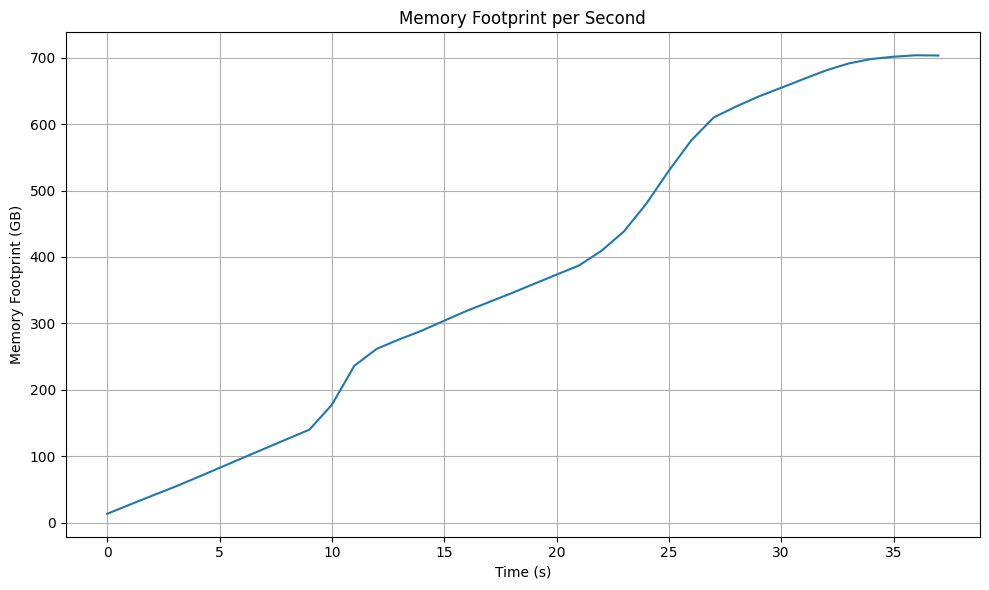

In [5]:
plt.figure(figsize=(10, 6))
plt.plot(time_points, memory_footprint / (1024 * 1024 * 1024))
plt.xlabel("Time (s)")
plt.ylabel("Memory Footprint (GB)")
plt.title("Memory Footprint per Second")
plt.grid(True)
plt.tight_layout()
plt.show()

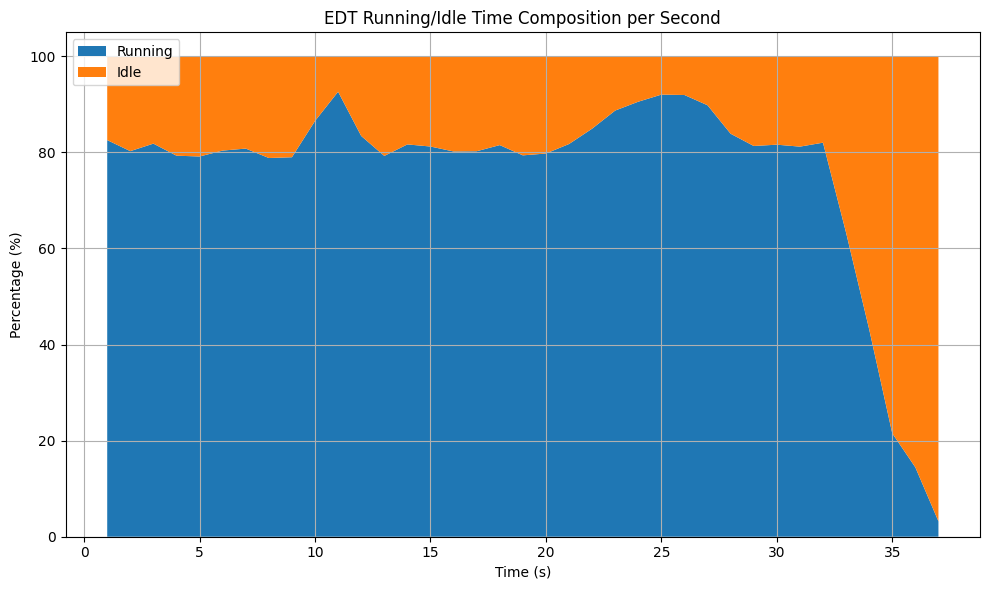

In [6]:
plt.figure(figsize=(10, 6))
plt.stackplot(
    time_points_excluded, edt_running_pct, edt_idle_pct, labels=["Running", "Idle"]
)
plt.xlabel("Time (s)")
plt.ylabel("Percentage (%)")
plt.title("EDT Running/Idle Time Composition per Second")
plt.legend(loc="upper left")
plt.grid(True)
plt.tight_layout()
plt.show()

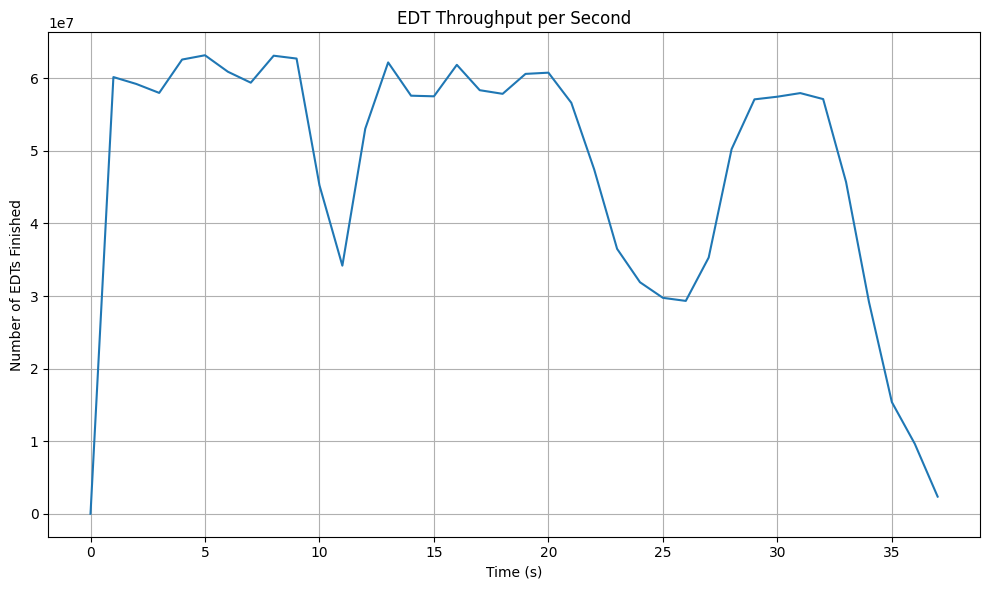

In [7]:
plt.figure(figsize=(10, 6))
plt.plot(time_points, edt_finished_diff)
plt.xlabel("Time (s)")
plt.ylabel("Number of EDTs Finished")
plt.title("EDT Throughput per Second")
plt.grid(True)
plt.tight_layout()
plt.show()

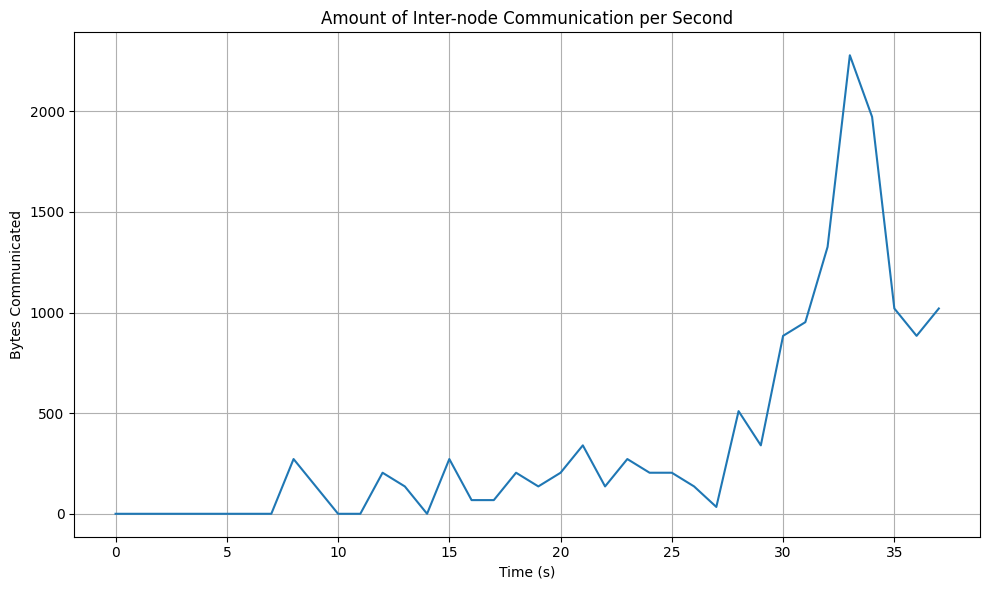

In [8]:
plt.figure(figsize=(10, 6))
plt.plot(time_points, comm_diff)
plt.xlabel("Time (s)")
plt.ylabel("Bytes Communicated")
plt.title("Amount of Inter-node Communication per Second")
plt.grid(True)
plt.tight_layout()
plt.show()

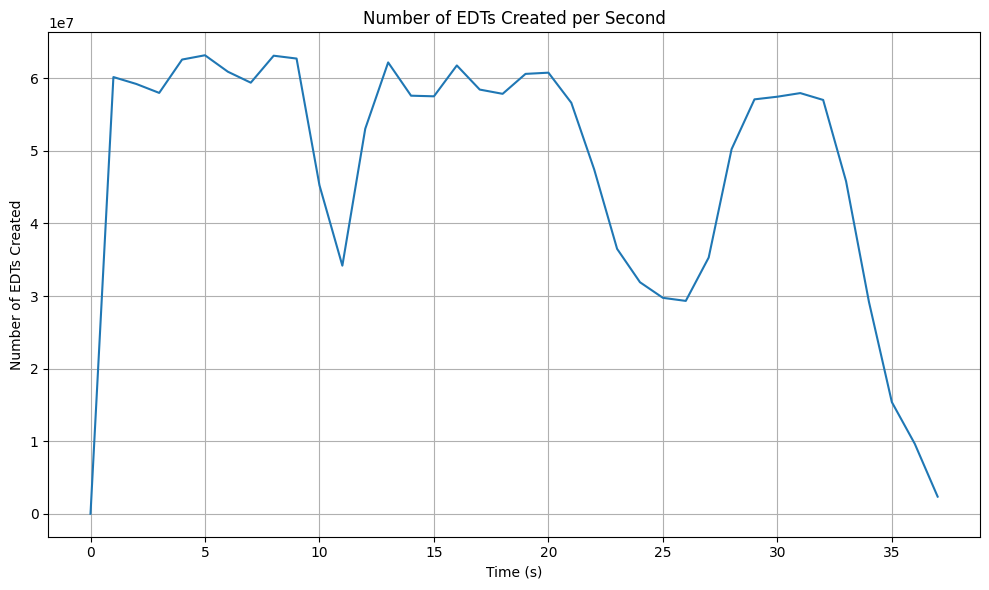

In [9]:
plt.figure(figsize=(10, 6))
plt.plot(time_points, edt_created_diff)
plt.xlabel("Time (s)")
plt.ylabel("Number of EDTs Created")
plt.title("Number of EDTs Created per Second")
plt.grid(True)
plt.tight_layout()
plt.show()

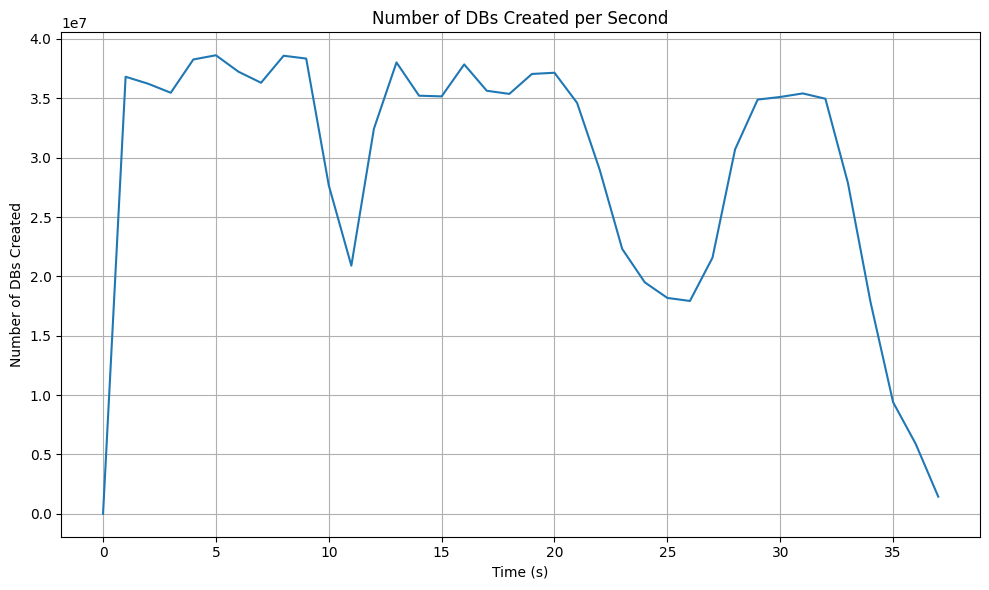

In [10]:
plt.figure(figsize=(10, 6))
plt.plot(time_points, dbs_created_diff)
plt.xlabel("Time (s)")
plt.ylabel("Number of DBs Created")
plt.title("Number of DBs Created per Second")
plt.grid(True)
plt.tight_layout()
plt.show()

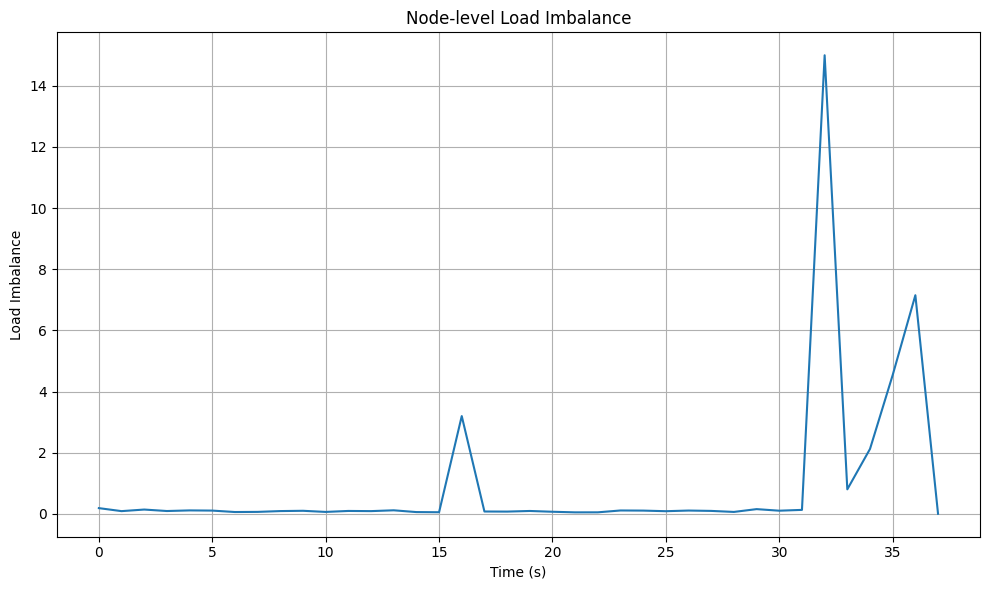

In [11]:
node_queue_sizes = []
num_nodes = len(json_files)

for capture_idx in range(len(time_points)):
    queue_sizes = []
    for node_id in range(num_nodes):
        node_data = df[df["nodeId"] == node_id]
        finished = node_data[
            (node_data["counter"] == "numEdtsFinished")
            & (node_data["captureIndex"] == capture_idx)
        ]["value"].values
        acquired = node_data[
            (node_data["counter"] == "numEdtsAcquired")
            & (node_data["captureIndex"] == capture_idx)
        ]["value"].values
        if len(finished) > 0 and len(acquired) > 0:
            queue_size = int(acquired[0]) - int(finished[0])
            if queue_size < 0:
                queue_size = 0
            queue_sizes.append(queue_size)
    node_queue_sizes.append(queue_sizes)

load_imbalance = []
for queue_sizes in node_queue_sizes:
    if len(queue_sizes) > 0:
        avg_queue = np.mean(queue_sizes)
        max_queue = np.max(queue_sizes)
        if avg_queue > 0:
            imbalance = (max_queue / avg_queue) - 1
        else:
            imbalance = 0
    else:
        imbalance = 0
    load_imbalance.append(imbalance)

plt.figure(figsize=(10, 6))
plt.plot(time_points, load_imbalance)
plt.xlabel("Time (s)")
plt.ylabel("Load Imbalance")
plt.title("Node-level Load Imbalance")
plt.grid(True)
plt.tight_layout()
plt.show()

In [12]:
print("Total EDTs finished per node:")
for json_file in json_files:
    with open(json_file, "r") as f:
        data = json.load(f)
        node_id = data["metadata"]["nodeId"]
        final_value = data["counters"]["numEdtsFinished"]["finalValue"]
        print(f"Node {node_id}: {final_value:,} EDTs")

Total EDTs finished per node:
Node 0: 117,247,568 EDTs
Node 1: 116,987,650 EDTs
Node 2: 114,085,915 EDTs
Node 3: 113,052,044 EDTs
Node 4: 112,194,378 EDTs
Node 5: 111,944,201 EDTs
Node 6: 111,319,952 EDTs
Node 7: 113,088,680 EDTs
Node 8: 112,657,736 EDTs
Node 9: 115,294,688 EDTs
Node 10: 116,698,361 EDTs
Node 11: 119,045,027 EDTs
Node 12: 125,882,826 EDTs
Node 13: 126,379,374 EDTs
Node 14: 121,109,886 EDTs
Node 15: 119,876,946 EDTs
